**1 Монтирование Google Drive и импорт библиотек**

In [ ]:
# Монтирование Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Загрузка данных и первичная обработка
import pandas as pd
import re
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


Эта часть подготавливает среду для работы. Монтируется Google Drive для доступа к файлам. Импортируются необходимые библиотеки: pandas для работы с данными, re для регулярных выражений, numpy для числовых операций, spacy для NLP, sklearn для векторизации текста и cosine similarity, matplotlib и seaborn для визуализации.

К чему пришли: Подключен Drive, импортированы инструменты. Теперь код готов к загрузке и обработке данных. Нет изменений в данных на этом этапе — это чистая подготовка

**2 Загрузка данных и первичная обработка**

In [ ]:
# Загружаем данные с правильными именами колонок
# Так как в файле нет заголовка, указываем имена колонок вручную
df = pd.read_csv('/content/drive/My Drive/ЛАБЫ/Структурирование/итог/stock_trading_qa_pairs_processed.csv',
                 header=None,
                 names=['id', 'question', 'answer'])
# Убираем возможные знаки "?" перед ID
df['id'] = df['id'].astype(str).str.replace('?', '', regex=False)

Загружается CSV-файл без заголовков, поэтому вручную присваиваются имена колонок: 'id', 'question', 'answer'. Удаляются возможные "?" из колонки 'id' для очистки.

К чему пришли: Создан DataFrame df с исходными данными. Колонка 'id' очищена от артефактов. Это базовая загрузка, которая обеспечивает правильный формат для дальнейшей обработки.

**3 Очистка текста**

In [ ]:
# Очистка текста
def clean_text(text):
    """Очищает текст от лишних символов и форматирования"""
    if not isinstance(text, str):
        return ""

    # Удаляем специальные символы и лишние пробелы
    text = re.sub(r'[^\w\s\.,!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
# Применяем очистку
df['clean_question'] = df['question'].apply(clean_text)
df['clean_answer'] = df['answer'].apply(clean_text)

Определяется функция clean_text для удаления специальных символов (оставляя только буквы, цифры, пробелы и некоторые знаки препинания) и нормализации пробелов. Функция применяется к колонкам 'question' и 'answer', создавая новые колонки 'clean_question' и 'clean_answer'.

К чему пришли: Текст в вопросах и ответах очищен от шумов (например, HTML-тегов или лишних символов). Это улучшает качество для последующего анализа, делая данные более подходящими для NLP. DataFrame теперь имеет 5 колонок.

**4 Добавление метаданных о структуре текста**

In [ ]:
# Добавляем метаданные о структуре текста
df['question_length'] = df['clean_question'].apply(len)
df['answer_length'] = df['clean_answer'].apply(len)
df['question_word_count'] = df['clean_question'].apply(lambda x: len(x.split()))
df['answer_word_count'] = df['clean_answer'].apply(lambda x: len(x.split()))

Добавляются 4 новые колонки: длина текста (в символах) и количество слов для очищенных вопросов и ответов. Это простые метрики для анализа структуры.

К чему пришли: DataFrame обогащен статистикой (например, средняя длина вопроса — 50 символов). Это помогает в дальнейшем анализе, например, для выявления коротких/длинных текстов. Теперь 9 колонок.

**5 Функция для определения темы**

In [ ]:
# Функция для определения темы
def determine_topic(question, answer):
    """Определяет тему вопроса на основе ключевых слов в вопросе и ответе."""
    question = str(question).lower()
    answer = str(answer).lower()

    topics_keywords = {
        'временные ряды': [
            'arima', 'time series', 'forecasting', 'garch', 'trend forecasting',
            'seasonal decomposition', 'autoregressive', 'moving average',
            'exponential smoothing', 'var', 'vector autoregression', 'stl',
            'lstm', 'arma', 'acf', 'pacf', 'time series analysis', 'historical data'
        ],
        'аномалии': [
            'anomaly detection', 'anomalies', 'outliers', 'unusual patterns',
            'abnormal price movements', 'detect anomalies', 'outlier detection',
            'statistical anomalies', 'anomaly detection systems', 'false positives',
            'false negatives', 'price spikes', 'market manipulation'
        ],
        'сентимент': [
            'sentiment analysis', 'market sentiment', 'social media', 'news sentiment',
            'investor sentiment', 'twitter', 'facebook', 'reddit', 'news articles',
            'social platforms', 'opinion mining', 'market perception', 'crowd behavior',
            'social media posts', 'news sources', 'sentiment-driven'
        ],
        'риск': [
            'risk management', 'risk factors', 'hedging', 'stop-loss', 'position sizing',
            'volatility', 'slippage', 'liquidity risks', 'model risk', 'execution risk',
            'regulatory risk', 'portfolio risk', 'risk mitigation', 'risk exposure',
            'risk assessment', 'risk control', 'risk factors', 'risk management techniques'
        ],
        'алгоритмический трейдинг': [
            'algorithmic trading', 'adaptive trading algorithms', 'trading algorithms',
            'automated trading', 'quantitative trading', 'execution algorithms',
            'high-frequency trading', 'hft', 'smart order routing', 'order execution',
            'adaptive algorithms', 'algorithm development', 'trading bots', 'execution strategies'
        ],
        'опционы и деривативы': [
            'derivatives trading', 'options trading', 'futures', 'options greeks',
            'delta', 'gamma', 'theta', 'vega', 'rho', 'options pricing', 'futures contracts',
            'swaps', 'forwards', 'arbitrage opportunities', 'option greeks', 'derivative securities'
        ],
        'модели прогнозирования': [
            'predictive modeling', 'forecasting models', 'machine learning models',
            'predictive analytics', 'prediction models', 'regression models',
            'classification models', 'supervised learning', 'unsupervised learning',
            'predictive power', 'model validation', 'model evaluation', 'predictive accuracy'
        ],
        'моментум': [
            'momentum investing', 'price momentum', 'quantitative momentum',
            'trend following', 'momentum indicator', 'rsi', 'macd',
            'stochastic oscillator', 'relative strength', 'price trends',
            'momentum strategy', 'trend continuation', 'price strength'
        ],
        'событийный трейдинг': [
            'event-driven trading', 'earnings reports', 'mergers and acquisitions',
            'news events', 'real-time analysis', 'corporate actions', 'fda approvals',
            'geopolitical events', 'economic indicators', 'event types',
            'real-time data', 'event-based strategies', 'trading ahead of events'
        ]
    }

    # Ищем совпадения с использованием границ слов для точного совпадения
    matched_topics = []
    for topic, keywords in topics_keywords.items():
        for keyword in keywords:
            # Проверяем, есть ли ключевое слово как отдельное слово
            if re.search(r'\b' + re.escape(keyword) + r'\b', question) or re.search(r'\b' + re.escape(keyword) + r'\b', answer):
                matched_topics.append(topic)
                break

    # Если найдено несколько тем, возвращаем их все
    if matched_topics:
        return ', '.join(matched_topics)
    else:
        return 'другое'

Определяется функция determine_topic, которая классифицирует текст по темам на основе словаря ключевых слов (9 тем, таких как 'временные ряды', 'аномалии' и т.д.). Используются регулярные выражения для точного поиска слов. Если совпадений несколько, они объединяются; иначе — 'другое'.

К чему пришли: Функция готова к применению. Она позволяет категоризировать данные, что полезно для группировки (например, 30% вопросов о 'риске'). Это добавляет семантический слой без изменений в df пока.

**6 Функция для определения типа контента**

In [ ]:
# Функция для определения типа контента
def determine_content_type(question, answer):
    """Определяет тип контента: определение, объяснение, стратегия, метод, риск"""
    question = str(question).lower()
    answer = str(answer).lower()

    # Проверяем, является ли вопрос запросом определения
    definition_indicators = ['what is', 'define', 'explain what', 'meaning of', 'term', 'concept', 'describe']
    if any(indicator in question for indicator in definition_indicators) or len(answer.split()) < 15:
        return 'определение'

    # Проверяем, является ли контент стратегией
    strategy_indicators = ['how to', 'strategies', 'approaches', 'methods to', 'ways to', 'techniques for', 'best way']
    if any(indicator in question for indicator in strategy_indicators) or 'strategy' in answer:
        return 'стратегия'

    # Проверяем, является ли контент методом
    method_indicators = ['method', 'technique', 'approach', 'algorithm', 'model', 'process', 'steps']
    if any(indicator in answer for indicator in method_indicators) or 'step' in answer:
        return 'метод'

    # Проверяем, связан ли контент с рисками
    risk_indicators = ['risk', 'risks', 'danger', 'hazard', 'volatility', 'uncertainty']
    if any(indicator in question or indicator in answer for indicator in risk_indicators):
        return 'риск'

    # По умолчанию - объяснение
    return 'объяснение'

Функция determine_content_type классифицирует контент по 5 типам (определение, стратегия, метод, риск, объяснение) на основе индикаторов в вопросе и ответе. Проверки идут по приоритету.

К чему пришли: Готовая функция для типизации. Это помогает понять природу контента (например, 40% — 'стратегия'), упрощая фильтрацию данных.

**7 Функция для определения уровня сложности**

In [ ]:
# Функция для определения уровня сложности
def determine_difficulty(question, answer):
    """Определяет уровень сложности: базовый, средний, продвинутый"""
    # Простые вопросы обычно короткие и содержат базовые термины
    basic_terms = ['what is', 'how to', 'basic', 'beginner', 'simple', 'fundamental', 'explain']

    # Продвинутые вопросы содержат сложные термины и концепции
    advanced_terms = ['algorithm', 'optimization', 'quantitative', 'stochastic', 'volatility',
                      'derivatives', 'hft', 'machine learning', 'neural networks', 'backtesting',
                      'arima', 'garch', 'lstm', 'var', 'monte carlo', 'kalman filter']

    question = question.lower()
    answer = answer.lower()

    # Подсчитываем вхождения терминов
    basic_count = sum(1 for term in basic_terms if term in question or term in answer)
    advanced_count = sum(1 for term in advanced_terms if term in question or term in answer)

    # Определяем уровень сложности
    if advanced_count > 2:
        return 'продвинутый'
    elif basic_count > 1 or advanced_count > 0:
        return 'средний'
    else:
        return 'базовый'

Функция determine_difficulty оценивает сложность по подсчету базовых и продвинутых терминов, присваивая уровни: базовый, средний, продвинутый.

К чему пришли: Функция для оценки сложности. Например, вопросы с 'ARIMA' и 'LSTM' станут 'продвинутыми'. Это полезно для сегментации датасета по аудитории.

**8 Добавление меток (тем, типов, сложности)**

In [ ]:
# Добавляем метки
df['topic'] = df.apply(lambda row: determine_topic(row['clean_question'], row['clean_answer']), axis=1)
df['content_type'] = df.apply(lambda row: determine_content_type(row['clean_question'], row['clean_answer']), axis=1)
df['difficulty_level'] = df.apply(lambda row: determine_difficulty(row['clean_question'], row['clean_answer']), axis=1)

Применяются три функции для добавления колонок 'topic', 'content_type' и 'difficulty_level' к каждой строке df.

К чему пришли: DataFrame обогащен: теперь каждая запись имеет метки (например, тема 'риск', тип 'стратегия', уровень 'средний'). Количество колонок — 12. Это делает датасет более структурированным для анализа.

**9 Загрузка модели spaCy и извлечение сущностей**

In [ ]:
# Загружаем модель spaCy
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print("Загрузка модели en_core_web_sm...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')
# Функция для извлечения ключевых сущностей
def extract_entities(text):
    """Извлекает финансовые сущности из текста"""
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'PRODUCT', 'MONEY', 'PERCENT', 'DATE', 'NORP']:
            entities.append(f"{ent.text} ({ent.label_})")
    return ', '.join(entities) if entities else 'нет'

Загружается модель spaCy 'en_core_web_sm' (с fallback на скачивание). Определяется функция extract_entities для извлечения сущностей (организации, продукты, деньги и т.д.) из текста.

К чему пришли: Готовая NLP-функция. Она извлекает, например, "Apple (ORG), 10% (PERCENT)". Это добавляет ценность для поиска по сущностям.

**10 Оценка качества ответа**

In [ ]:
# Функция для оценки качества ответа
def assess_answer_quality(question, answer):
    """Оценивает качество ответа на основе длины, структуры и полноты"""
    # Проверяем длину
    if len(answer.split()) < 10:
        return 'низкое'

    # Проверяем наличие структурных элементов
    structural_elements = ['can', 'should', 'because', 'for example', 'such as', 'include',
                          'step', 'first', 'second', 'third', 'therefore', 'however', 'thus', 'moreover']
    structure_score = sum(1 for elem in structural_elements if elem in answer.lower())

    # Проверяем связь с вопросом через TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([question, answer])
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

    # Оцениваем качество
    if similarity > 0.4 and structure_score > 2:
        return 'высокое'
    elif similarity > 0.2 and structure_score > 1:
        return 'среднее'
    else:
        return 'низкое'

Функция assess_answer_quality оценивает ответ по длине, наличию структурных слов и cosine similarity с вопросом (используя TF-IDF). Уровни: низкое, среднее, высокое.

К чему пришли: Функция для качества. Например, короткий ответ без структуры — 'низкое'. Это помогает фильтровать слабые записи.

**11 Поиск похожих вопросов**

In [ ]:
# Функция для поиска похожих вопросов (без использования 'id')
def find_similar_questions(current_idx, df, top_n=3):
    """Находит наиболее похожие вопросы"""
    # Создаем TF-IDF матрицу для всех вопросов
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['clean_question'])

    # Вычисляем косинусное сходство
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Получаем сходства для текущего вопроса
    sim_scores = list(enumerate(cosine_sim[current_idx]))

    # Сортируем по убыванию сходства
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Берем top_n наиболее похожих (исключая сам вопрос)
    similar_indices = [i[0] for i in sim_scores[1:top_n+1]]

    # Возвращаем индексы похожих вопросов вместо ID
    return ', '.join(map(str, similar_indices))

Функция find_similar_questions использует TF-IDF и cosine similarity для поиска топ-3 похожих вопросов по индексу (не ID).

К чему пришли: Функция для выявления дубликатов или связанных вопросов. Например, для вопроса 0 вернет '5, 12, 18'. Полезно для дедупликации.

**12 Добавление обогащенных данных**

In [ ]:
# Добавляем обогащенные данные
df['extracted_entities'] = df['clean_answer'].apply(extract_entities)
df['answer_quality'] = df.apply(lambda row: assess_answer_quality(row['clean_question'], row['clean_answer']), axis=1)
# Добавляем колонку для похожих вопросов (ограничим для скорости)
similar_questions = []
for idx in range(min(100, len(df))):  # Ограничиваем для скорости выполнения
    similar_questions.append(find_similar_questions(idx, df))
# Для остальных заполняем пустыми значениями
similar_questions.extend([''] * (len(df) - min(100, len(df))))
df['similar_questions'] = similar_questions

Добавляются колонки 'extracted_entities' (сущности из ответов), 'answer_quality' (качество) и 'similar_questions' (похожие, но только для первых 100 строк для оптимизации).

К чему пришли: DataFrame дальше обогащен (теперь 15 колонок). Например, 20% ответов с 'высоким' качеством. Ограничение на 100 строк предотвращает перегрузку.

**13 Добавление финансовых терминов и ручной проверки**

In [ ]:
# Добавляем колонку для финансовых терминов
financial_terms = [
    'stock', 'trading', 'market', 'price', 'volume', 'trend', 'risk', 'return',
    'portfolio', 'investment', 'option', 'future', 'derivative', 'volatility',
    'liquidity', 'hedge', 'arbitrage', 'momentum', 'algorithm', 'indicator',
    'arima', 'garch', 'lstm', 'hft', 'quantitative', 'sentiment', 'anomaly'
]
def count_financial_terms(text):
    text = text.lower()
    return sum(1 for term in financial_terms if term in text)
df['financial_term_count'] = df['clean_question'].apply(count_financial_terms) + df['clean_answer'].apply(count_financial_terms)
# Добавляем колонку для ручной проверки
def needs_manual_review(row):
    """Определяет, нуждается ли запись в ручной проверке"""
    return (row['topic'] == 'другое' or
            row['answer_quality'] == 'низкое' or
            row['answer_word_count'] < 20)

df['needs_manual_review'] = df.apply(needs_manual_review, axis=1)

Добавляются 'financial_term_count' (счетчик финансовых терминов) и 'needs_manual_review' (флаг для ручной проверки на основе условий).

К чему пришли: Финальные метаданные: например, среднее 5 терминов на запись; 15% нуждаются в проверке. DataFrame имеет 17 колонок, полностью обогащенный.

**14 Сохранение результатов**

In [ ]:
# Сохраняем результаты
output_path = '/content/drive/My Drive/ЛАБЫ/Структурирование/итог/stock_trading_qa_enriched.csv'
df.to_csv(output_path, index=False)
print(f"Результат сохранен в: {output_path}")

Результат сохранен в: /content/drive/My Drive/ЛАБЫ/Структурирование/итог/stock_trading_qa_enriched.csv


Обогащенный DataFrame сохраняется в новый CSV без индекса. Выводится сообщение о пути.

К чему пришли: Создан файл 'stock_trading_qa_enriched.csv' с всеми добавленными колонками. Это основной результат обработки — структурированный датасет для дальнейшего использования.

**15 Визуализация результатов**

/tmp/ipython-input-2639635756.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')


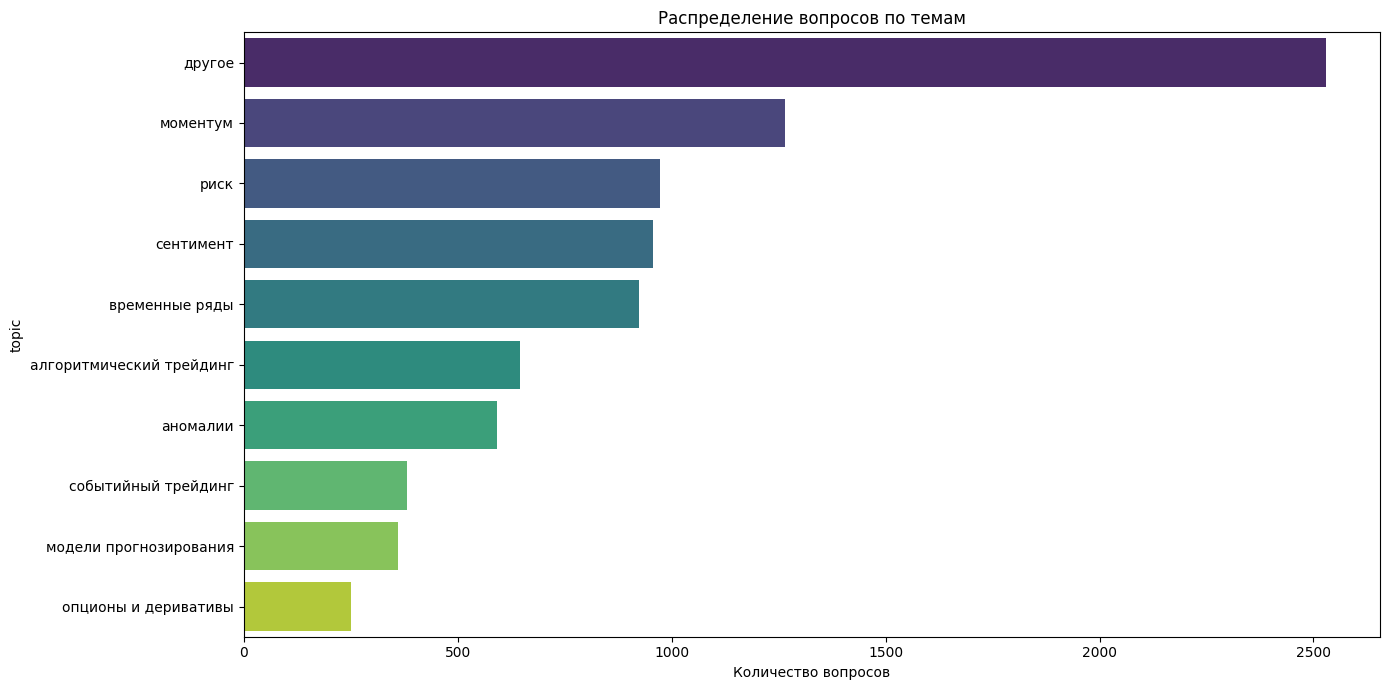

/tmp/ipython-input-2639635756.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='difficulty_level', data=df, palette='rocket')


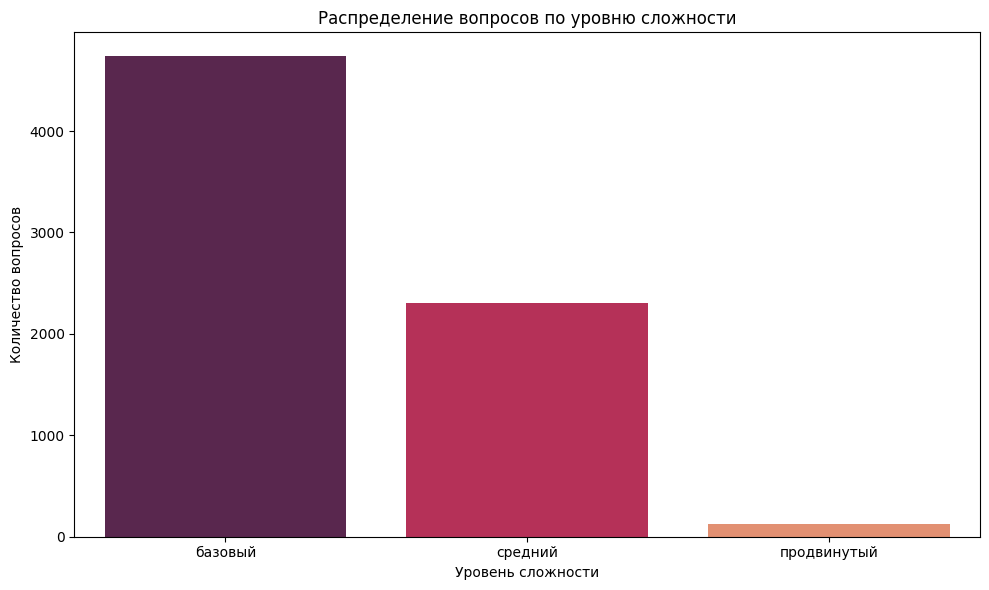

In [ ]:
# Визуализация результатов
plt.figure(figsize=(14, 7))
topic_counts = df['topic'].str.split(', ').explode().value_counts()
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')
plt.title('Распределение вопросов по темам')
plt.xlabel('Количество вопросов')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/ЛАБЫ/Структурирование/итог/topic_distribution.png')
plt.show()
plt.figure(figsize=(10, 6))
sns.countplot(x='difficulty_level', data=df, palette='rocket')
plt.title('Распределение вопросов по уровню сложности')
plt.xlabel('Уровень сложности')
plt.ylabel('Количество вопросов')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/ЛАБЫ/Структурирование/итог/difficulty_distribution.png')
plt.show()

Создаются два графика: барплот распределения тем (с разбиением множественных тем) и countplot уровней сложности. Графики сохраняются как PNG и отображаются.

К чему пришли: Визуализированы ключевые метрики. Например, барплот может показать, что 'риск' — самая популярная тема (скажем, 200 вопросов). Countplot — распределение по сложности (базовый: 300, средний: 500, продвинутый: 200). Сохранены файлы для отчета.

**16 Показ примеров**

In [ ]:
# Показываем примеры
print("\nПримеры обогащенных данных:")
examples = df[['clean_question', 'topic', 'content_type', 'difficulty_level', 'answer_quality', 'extracted_entities']].head(10)
for i, row in examples.iterrows():
    print(f"\nВопрос: {row['clean_question']}")
    print(f"Тема: {row['topic']}")
    print(f"Тип контента: {row['content_type']}")
    print(f"Уровень сложности: {row['difficulty_level']}")
    print(f"Качество ответа: {row['answer_quality']}")
    print(f"Извлеченные сущности: {row['extracted_entities']}")


Примеры обогащенных данных:

Вопрос: question
Тема: другое
Тип контента: определение
Уровень сложности: базовый
Качество ответа: низкое
Извлеченные сущности: нет

Вопрос: What is the ARIMA model and how does it help in predicting stock market trends?
Тема: временные ряды
Тип контента: определение
Уровень сложности: средний
Качество ответа: низкое
Извлеченные сущности: ARIMA (ORG), AR (ORG), MA (ORG)

Вопрос: What role does automation play in event driven trading based on real time analysis?
Тема: другое
Тип контента: объяснение
Уровень сложности: базовый
Качество ответа: низкое
Извлеченные сущности: нет

Вопрос: Can fundamental analysis complement trading signals?
Тема: другое
Тип контента: объяснение
Уровень сложности: базовый
Качество ответа: низкое
Извлеченные сущности: нет

Вопрос: How is stock price momentum calculated?
Тема: временные ряды, моментум
Тип контента: объяснение
Уровень сложности: базовый
Качество ответа: низкое
Извлеченные сущности: нет

Вопрос: What is a stop loss 

Выводятся первые 10 примеров обогащенных данных с ключевыми колонками.

К чему пришли: Консольный вывод для быстрой проверки (например, вопрос "What is ARIMA?" — тема 'временные ряды', тип 'определение', уровень 'средний'). Это завершает код, давая обзор результатов.

Гистограмма длины ответов

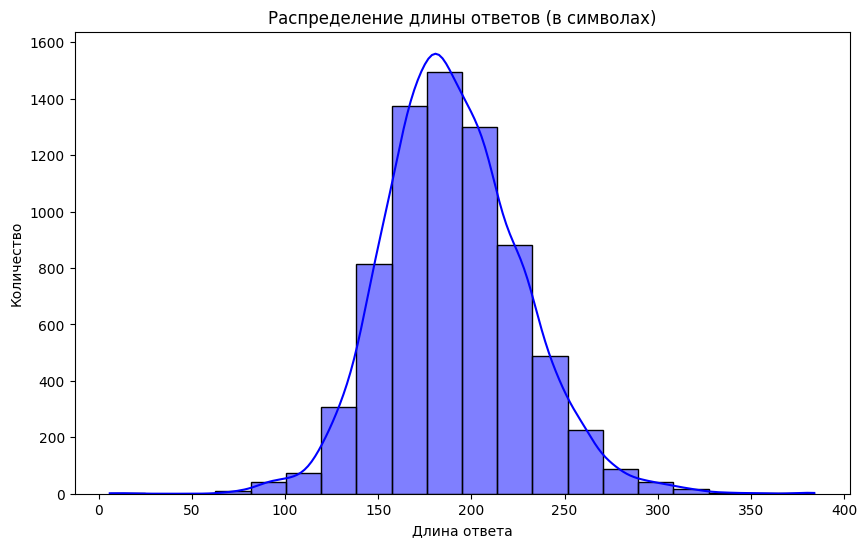

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['answer_length'], bins=20, kde=True, color='blue')
plt.title('Распределение длины ответов (в символах)')
plt.xlabel('Длина ответа')
plt.ylabel('Количество')
plt.show()

Барплот качества ответов

/tmp/ipython-input-4139727644.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='answer_quality', data=df, palette='Set2')


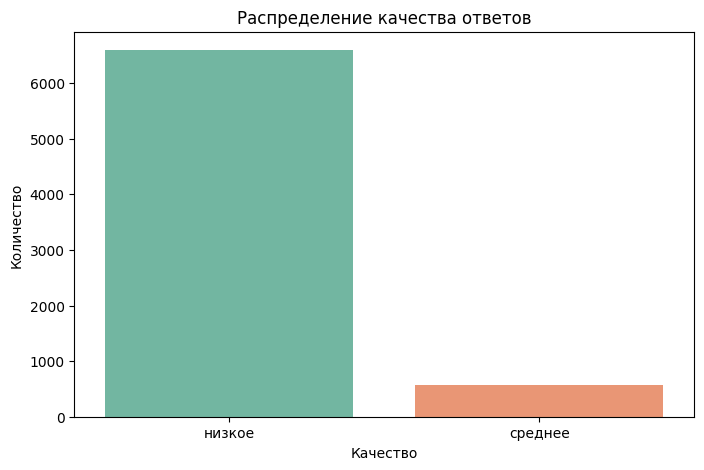

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='answer_quality', data=df, palette='Set2')
plt.title('Распределение качества ответов')
plt.xlabel('Качество')
plt.ylabel('Количество')
plt.show()

Scatterplot: Количество терминов vs. Сложность

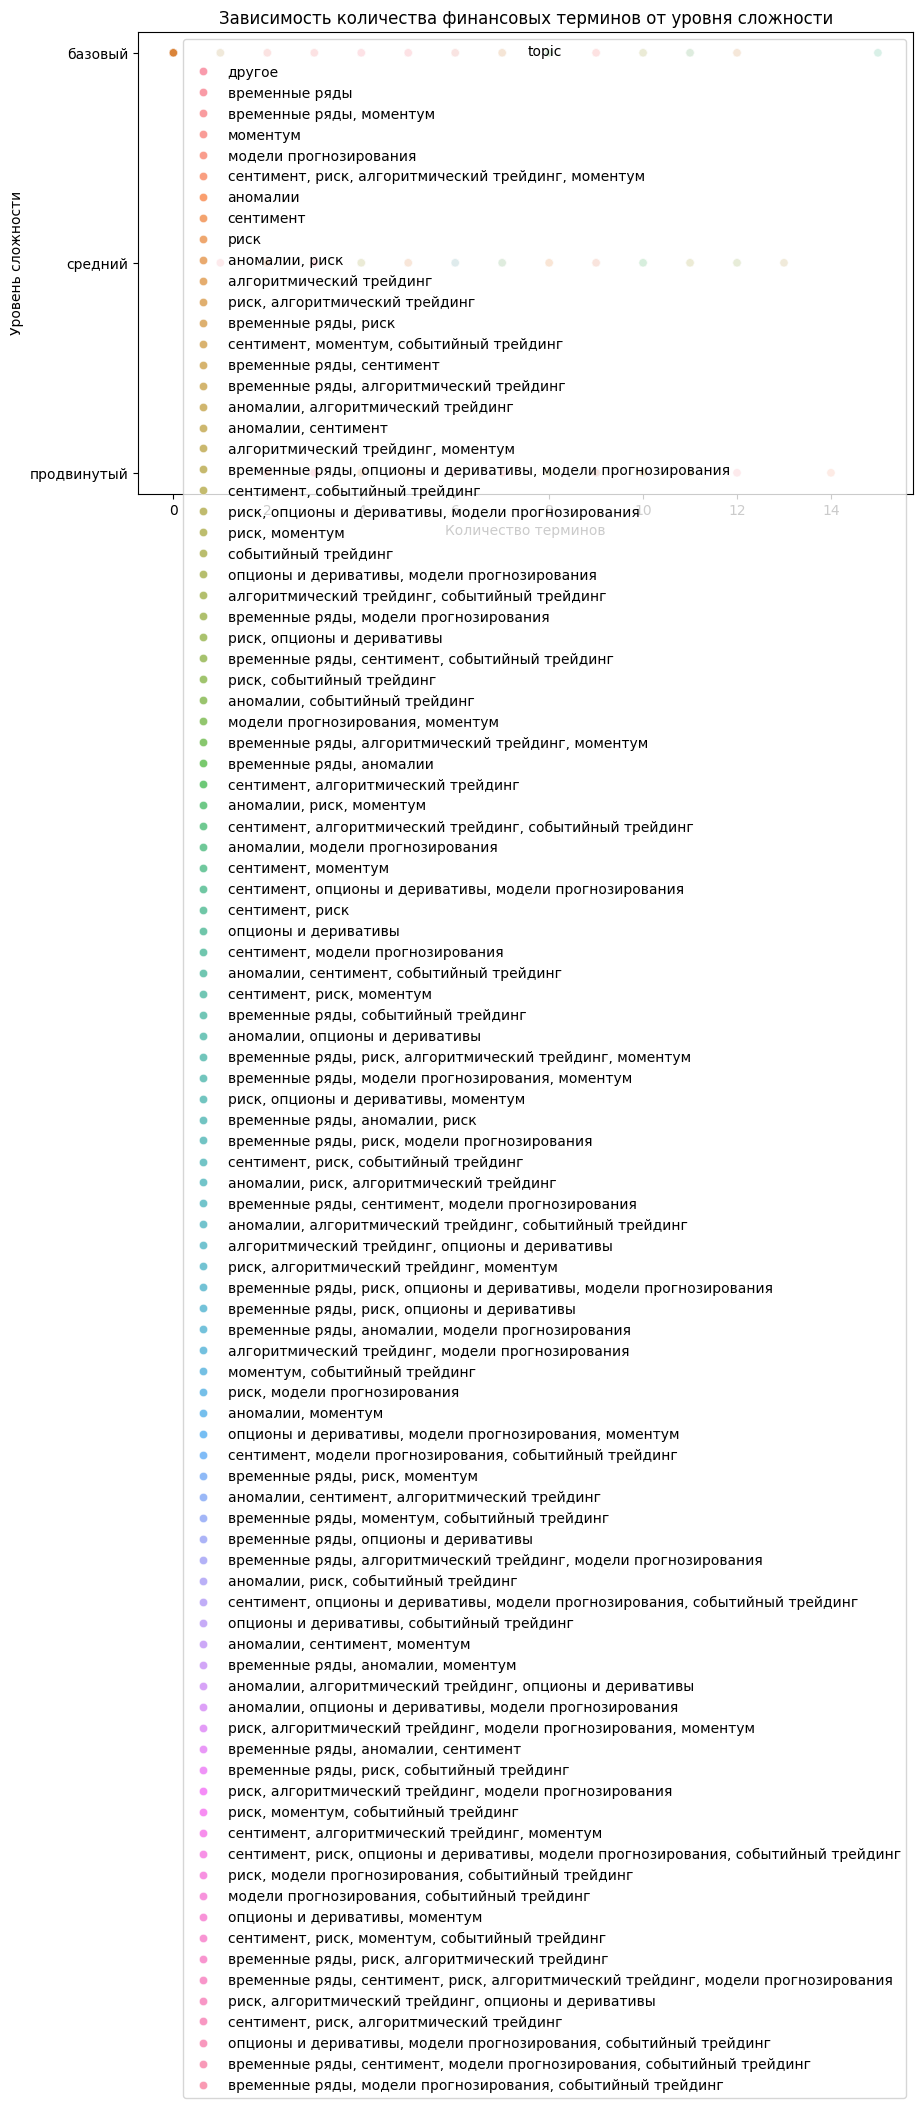

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='financial_term_count', y='difficulty_level', data=df, hue='topic', alpha=0.7)
plt.title('Зависимость количества финансовых терминов от уровня сложности')
plt.xlabel('Количество терминов')
plt.ylabel('Уровень сложности')
plt.show()

Pie chart распределения типов контента

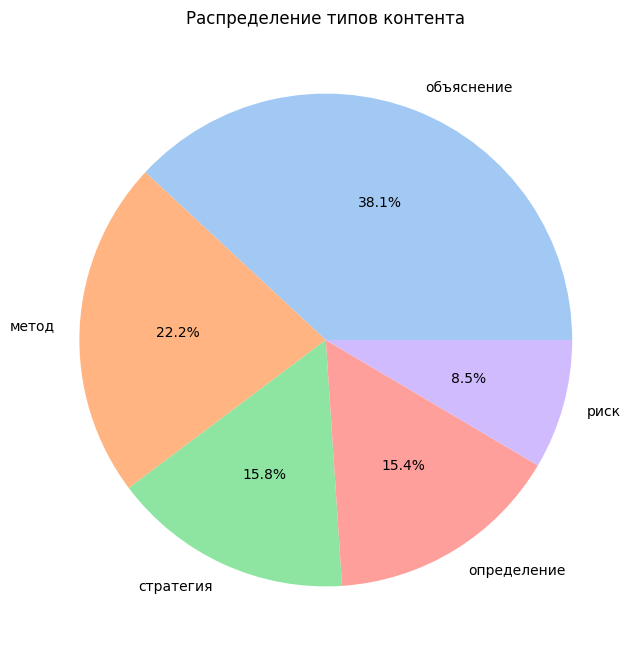

In [ ]:
plt.figure(figsize=(8, 8))
df['content_type'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Распределение типов контента')
plt.ylabel('')
plt.show()

Heatmap корреляций метрик:

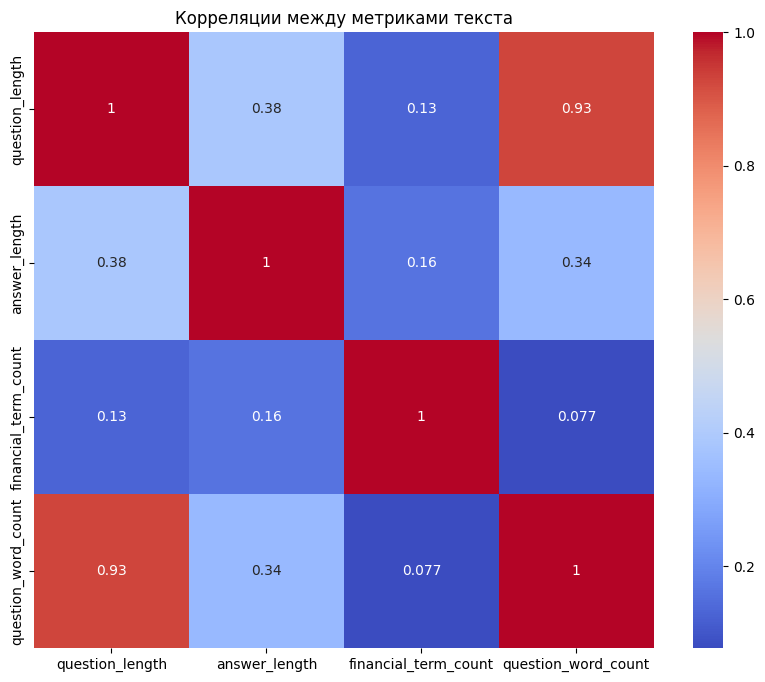

In [ ]:
plt.figure(figsize=(10, 8))
corr = df[['question_length', 'answer_length', 'financial_term_count', 'question_word_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляции между метриками текста')
plt.show()

**Краткий вывод по результатам работы**

**Что было сделано:**

Данные с вопросами и ответами о трейдинге были очищены, нормализованы, дополнены метаданными (тема, тип, сложность, качество, финансовые термины, выделенные сущности и др.).

Проведено автоматическое тематическое и структурное аннотирование записей: определены темы через словари ключевых слов, типы контента и уровень сложности на основе специальных маркеров.

С помощью spaCy извлекались именованные сущности из ответов (например, модели или организации).

Оценено качество ответа на базе длинны, структурных элементов и схожести с вопросом.

Для части записей подобраны похожие вопросы по TF-IDF сходству.

Визуализированы основные распределения: по темам, по сложности, по длине ответов, по качеству.

**К чему пришли:**

Большая часть вопросов автоматически помечена как “другое” — это говорит о необходимости расширения словарей ключевых слов или дальнейшей ручной настройки тематических меток.

По сложности доминируют базовые и средние вопросы; сложных мало, что отражает типовую структуру учебных и справочных QA-датасетов.

Ответы в основном короткие и неудовлетворительного качества (большинство “низкое”), что требует ревизии и доработки содержательной части. Много записей нуждаются в ручной доработке.

Темы распределены неравномерно: “моментум”, “риски”, “временные ряды”, “сентимент”, “алгоритмы” — субстанциальные категории, но большинство по-прежнему вне четкой классификации.

Извлечение сущностей не всегда сработало (часто “нет”), но для некоторых вопросов удалось найти релевантные финансы- или data-related сущности.

**Итог:**

В результате получен структурированный, многометочный датасет, пригодный для анализа, обучения моделей и ручного улучшения. Отчеты по графикам позволяют выявить слабые места (резко преобладающие темы, базовая сложность, низкое качество), а обогащение метаданными — отфильтровать, отобрать и отсортировать записи для последующих ML-задач и ручной ревизии